In [173]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import preprocessing
plt.rc("font", size=14)

from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from skimage.morphology import skeletonize,square,dilation 
from PVBM.GeometricalAnalysis import GeometricalVBMs
from PIL import Image,ImageFilter
from glob import glob

from itertools import combinations

# Data

In [174]:
data = pd.read_csv('morphological_data/morph_stats_test.csv', index_col=0)
data = data.drop('image_name', axis=1)
data = data.drop('prob_0', axis=1)
data = data.drop('prob_1', axis=1)
data = data.astype({'status': 'int32', 'pred_status': 'int32'})
col_names = data.columns.values.tolist()[1:]
col_names.append(data.columns.values.tolist()[0])
data = data[col_names]
data = data.reindex(columns=col_names)
data

,area,endpoints,intersection_points,median_tortuosity,tortuosity_index,length,perimeter,BA_mean,BA_std,BA_median,D0,D1,D2,SL,pred_status,status
1,0.241146,242.0,1016.0,1.078423,1.091948,41.755515,89.058218,97.409416,41.466111,92.045408,1.568623,1.554390,1.537124,0.571254,1,0
2,0.267278,316.0,1259.0,1.078081,1.086922,47.163914,99.976946,101.127149,42.166498,98.130102,1.586201,1.570124,1.553828,0.634216,0,0
3,0.369984,104.0,374.0,1.081524,1.110732,26.060224,55.752467,103.657447,42.680454,108.913930,1.499439,1.492701,1.482476,0.611228,0,0
4,0.363058,129.0,487.0,1.077366,1.085169,29.545954,61.330782,95.715414,40.722771,92.205188,1.518087,1.509306,1.498002,0.755765,0,0
5,0.361933,102.0,418.0,1.081569,1.100095,28.290753,59.807798,100.286770,42.567115,103.100874,1.512124,1.498284,1.483765,0.753090,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.180328,113.0,157.0,1.076809,1.082496,13.327404,29.089298,88.199197,52.168828,91.564415,1.505306,1.497587,1.471764,0.434897,1,1
67,0.244646,106.0,194.0,1.078443,1.108702,18.889354,41.999986,87.628002,52.921482,85.236373,1.516205,1.511284,1.500414,0.408745,1,1
68,0.292205,58.0,194.0,1.080999,1.103769,19.932173,43.875879,88.508081,51.369070,90.000000,1.541371,1.529076,1.522426,0.721521,1,1
69,0.162429,104.0,118.0,1.088718,1.138351,12.248699,27.888638,91.656457,50.824058,83.088773,1.438518,1.411320,1.389260,0.516779,1,1


# Plots

## Histograms

In [175]:
for name in col_names[:-2]:

    plt.title(name)
    data.loc[data['status'] == 0, name].plot.kde(label='control')
    data.loc[data['status'] == 1, name].plot.kde(label='retina')
    plt.legend()
    plt.savefig('morphological_data/hist_plots/by_status/'+name+'_stat_dens.jpg')
    plt.close()

    plt.title(name)
    data.loc[data['pred_status'] == 0, name].plot.kde(label='control')
    data.loc[data['pred_status'] == 1, name].plot.kde(label='retina')
    plt.legend()
    plt.savefig('morphological_data/hist_plots/by_pred_status/'+name+'_pred_stat_dens.jpg')
    plt.close()

for name in col_names:
    plt.title(name)
    data[name].plot.hist()
    plt.savefig('morphological_data/hist_plots/general/'+name+'_hist.jpg')
    plt.close()

fig, ax = plt.subplots()
data['status'].plot.hist(alpha=0.5, rwidth=0.9, bins=2, label='real', legend=True)
data['pred_status'].plot.hist(alpha=0.5, rwidth=0.7, bins=2, label='predicted', legend=True)
plt.title('status')
ax.set_xticks([0.25,0.75])
ax.set_xticklabels(['healthy', 'retina'])
plt.savefig('morphological_data/hist_plots/status_hist.jpg')
plt.close()

## Correlation plots

In [176]:
pairs = sorted(map(sorted, combinations(set(col_names[:-2]), 2)))

for pair in pairs:
    sn.regplot(data[data['status'] == 0] , x=pair[0],y=pair[1], color='blue', label='control')
    sn.regplot(data[data['status'] == 1] , x=pair[0],y=pair[1], color='red' , label='retina')
    r_cont, _ = pearsonr(data.loc[data['status'] == 0, pair[0]], data.loc[data['status'] == 0, pair[1]])
    r_ret, _ = pearsonr(data.loc[data['status'] == 1, pair[0]], data.loc[data['status'] == 1, pair[1]])
    plt.title(f'corr_control: {r_cont:.2f}  corr_retina: {r_ret:.2f}')
    plt.legend()
    plt.savefig('morphological_data/corr_plots/by_status/'+pair[1]+'_x_'+pair[0]+'.jpg')
    plt.close()
    sn.regplot(data[data['pred_status'] == 0] , x=pair[0],y=pair[1], color='blue', label='control')
    sn.regplot(data[data['pred_status'] == 1] , x=pair[0],y=pair[1], color='red' , label='retina')
    r_cont, _ = pearsonr(data.loc[data['pred_status'] == 0, pair[0]], data.loc[data['pred_status'] == 0, pair[1]])
    r_ret, _ = pearsonr(data.loc[data['pred_status'] == 1, pair[0]], data.loc[data['pred_status'] == 1, pair[1]])
    plt.title(f'corr_control: {r_cont:.2f}  corr_retina: {r_ret:.2f}')
    plt.legend()
    plt.savefig('morphological_data/corr_plots/by_pred_status/'+pair[1]+'_x_'+pair[0]+'.jpg')
    plt.close()

## Arc lenght histograms

In [177]:
paths_list = glob('data/data_m_vessel/test/control/*') + glob('data/data_m_vessel/test/retina/*')

fives, aria, hrf = [], [], []
con, ret = [], []

for i, path in enumerate(paths_list):

    index = i+1
    
    name = path.split('\\')[-1]
    stat = path.split('\\')[0].split('/')[-1]
    if name.split('.')[-1] == 'png':
        pixel_size = 2/2048
        dataset = 'FIVES'
    else:
        if name[0] == 'a':
            pixel_size = 2/708
            dataset = 'ARIA'
        else:
            pixel_size = 2/3250
            dataset = 'HRF'

    segmentation = Image.open(path)
    segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))
    segmentation = np.array(segmentation)/255
    if len(segmentation.shape) == 3 : segmentation = segmentation[:,:,0]
    skeleton = skeletonize(segmentation) 

    median_tor, length, chord, arc, _ = GeometricalVBMs().compute_tortuosity_length(skeleton)
    arc = (np.array(arc) * pixel_size).tolist()

    if dataset == 'FIVES': fives += arc
    elif dataset == 'ARIA': aria += arc
    else: hrf += arc
    if stat == 'control': con += arc
    else: ret += arc

    plt.hist(arc)
    plt.title(dataset+': '+name)
    plt.savefig('morphological_data/arc_lenght_plots_for_img/plots/'+dataset+'_'+name.split('.')[0]+'.jpg')
    plt.close()

plt.title('FIVES')
plt.hist(fives, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/FIVES_arc_len_hist.jpg')
plt.close()
plt.title('ARIA')
plt.hist(aria, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/ARIA_arc_len_hist.jpg')
plt.close()
plt.title('HRF')
plt.hist(hrf, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/HRF_arc_len_hist.jpg')
plt.close()

plt.title('arc lenght for datasets')
sn.kdeplot(fives, color='red', fill=True, alpha=.3, linewidth=0, label='FIVES')
sn.kdeplot(aria, color='blue', fill=True, alpha=.3, linewidth=0, label='ARIA')
sn.kdeplot(hrf, color='green', fill=True, alpha=.3, linewidth=0, label='HRF')
plt.legend()
plt.savefig('morphological_data/arc_lenght_plots_for_img/arc_len_data_dens.jpg')
plt.close()

plt.title('arc lenght for groups')
sn.kdeplot(con, color='blue', fill=True, alpha=.3, linewidth=0, label='control')
sn.kdeplot(ret, color='red', fill=True, alpha=.3, linewidth=0, label='retina')
plt.legend()
plt.savefig('morphological_data/arc_lenght_plots_for_img/arc_len_groups_dens.jpg')
plt.close()


## Mosaic plot

In [178]:
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
def my_hist(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sn.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    ax.hist(x, label=label, color=color)
    
sn.set(style="ticks", color_codes=True)
# iris = sn.load_dataset('iris')
g = sn.pairplot(data, kind="reg", plot_kws={'line_kws':{'color':'red'}})

for ax in g.axes.flat:
  ax.tick_params(axis='both', labelleft=True, labelbottom=True)

plt.subplots_adjust(wspace=0.7, hspace=0.3)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
  xlabel = ax.xaxis.get_label_text()
  xlabels.append(xlabel)
for ax in g.axes[:,0]:
  ylabel = ax.yaxis.get_label_text()
  ylabels.append(ylabel)

for i in range(len(xlabels)):
  for j in range(len(ylabels)):
    if i == j:
      g.axes[j,i].yaxis.set_visible(False)
      g.axes[j,i].xaxis.set_label_text(xlabels[i], visible=True)
      sn.despine(ax=g.axes[j,i], left=True, top=True, right=False)
    else:
      g.axes[j,i].xaxis.set_label_text(xlabels[i], visible=True)
      g.axes[j,i].yaxis.set_label_text(ylabels[j], visible=True)

g.map_upper(hide_current_axis)
g.map_diag(hide_current_axis)
g.map_lower(corrfunc)
g.map_diag(my_hist)

plt.savefig('morphological_data/pairgrid.jpg')
plt.close()

# Analysis

## Correlation Matrix

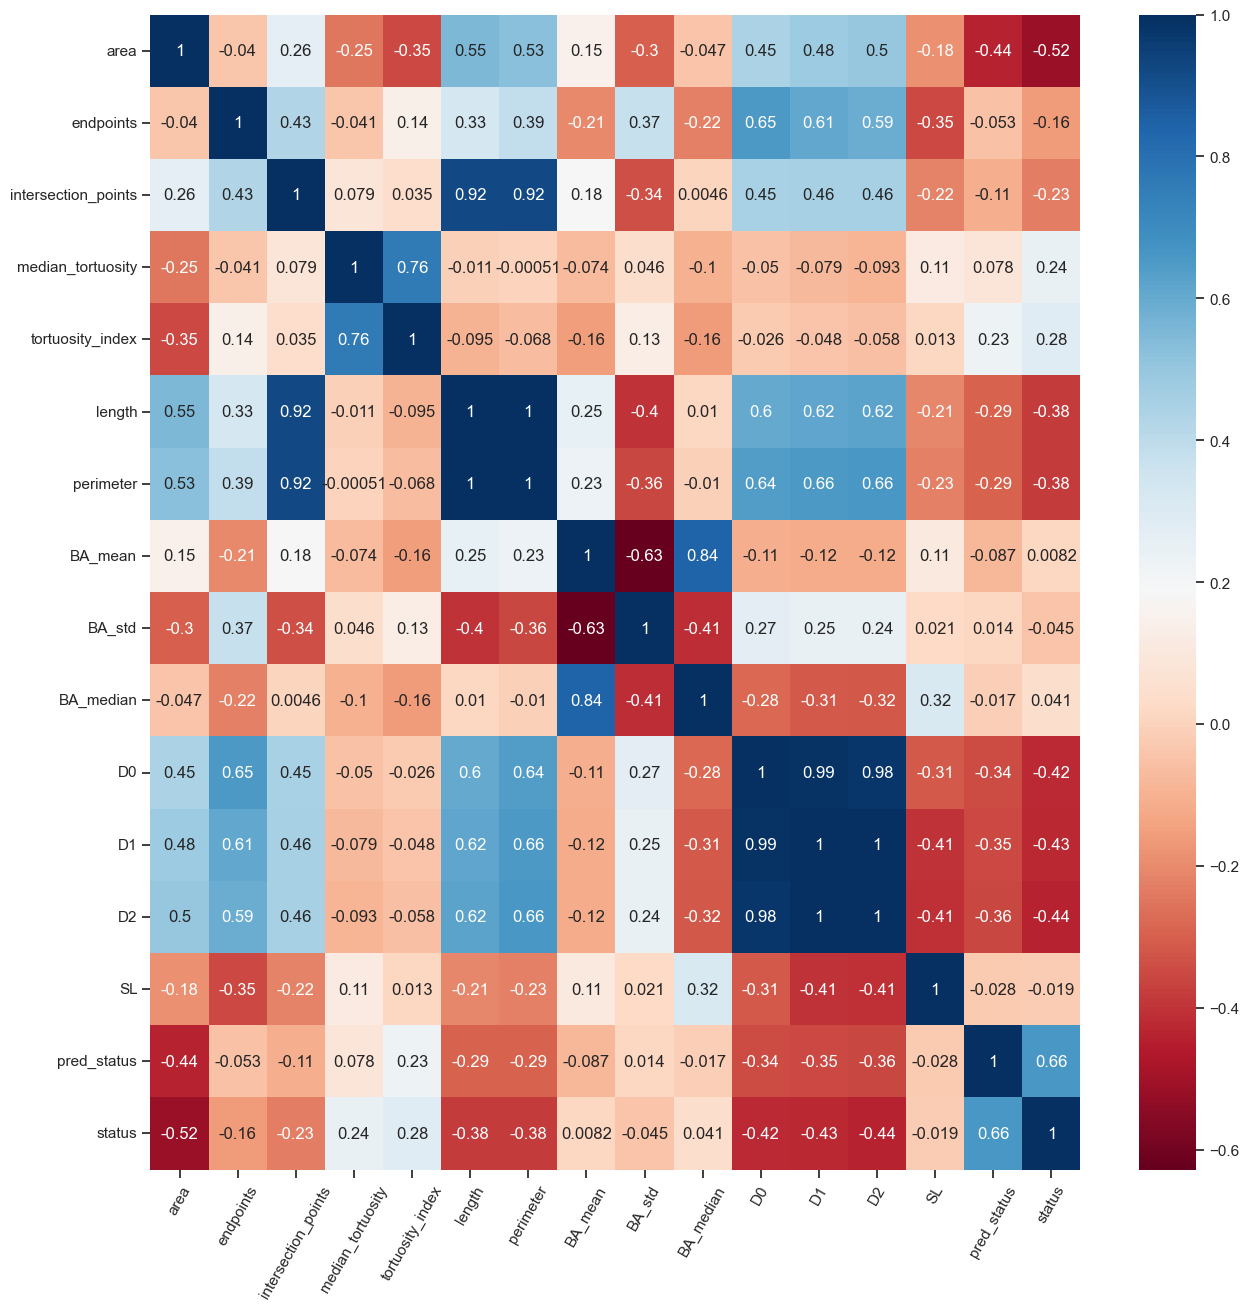

In [179]:
corr_matrix = data.corr()
plt.figure(figsize=(15,15))
sn.heatmap(corr_matrix, annot=True, cmap='RdBu')
plt.xticks(rotation = 60) 
plt.show()

## Logistic Regression

In [204]:
print('For real status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = LogisticRegression()

model.fit(X_train_std, y_train)

print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_std)))
print('Training F1: ', f1_score(y_train, model.predict(X_train_std)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_std)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_std)))

sfs1 = SFS(model, 
           k_features="best",
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[:-2][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_sele)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_sele)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_sele)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_sele)))


For real status
Training accuracy: 0.8214285714285714
Training F1:  0.8076923076923077
Testing Accuracy:  0.6428571428571429
Testing F1:  0.6153846153846153
selected features:
 ['intersection_points', 'median_tortuosity', 'length', 'perimeter', 'BA_mean', 'BA_std', 'BA_median', 'D0', 'D1', 'D2', 'SL']
Training accuracy: 0.7857142857142857
Training F1:  0.7777777777777779
Testing Accuracy:  0.6428571428571429
Testing F1:  0.6153846153846153


In [205]:
print('For predicted status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -2].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = LogisticRegression()

model.fit(X_train_std, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_std)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_std)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_std)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_std)))

sfs1 = SFS(model, 
           k_features="best",
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[:-2][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_sele)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_sele)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_sele)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_sele)))

For predicted status
Training accuracy: 0.7678571428571429
Training F1:  0.7868852459016393
Testing Accuracy:  0.6428571428571429
Testing F1:  0.7058823529411764
selected features:
 ['area', 'BA_median', 'SL']
Training accuracy: 0.7321428571428571
Training F1:  0.7457627118644068
Testing Accuracy:  0.7142857142857143
Testing F1:  0.75


## K Neighbors Classifier

In [206]:
print('For real status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train_std, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_std)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_std)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_std)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_std)))
sfs1 = SFS(model, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[:-2][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_sele)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_sele)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_sele)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_sele)))

For real status
Training accuracy: 0.8571428571428571
Training F1:  0.8571428571428571
Testing Accuracy:  0.7857142857142857
Testing F1:  0.7999999999999999
selected features:
 ['area', 'intersection_points', 'tortuosity_index', 'length', 'BA_mean', 'D1', 'D2', 'SL']
Training accuracy: 0.8928571428571429
Training F1:  0.888888888888889
Testing Accuracy:  0.7857142857142857
Testing F1:  0.7999999999999999


In [207]:
print('For predicted status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -2].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train_std, y_train)

print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_std)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_std)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_std)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_std)))

sfs1 = SFS(model, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[:-2][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)
print('Training accuracy:', accuracy_score(y_train, model.predict(X_train_sele)))
print('Training F1: ', f1_score(y_train,model.predict(X_train_sele)))
print('Testing Accuracy: ', accuracy_score(y_test, model.predict(X_test_sele)))
print('Testing F1: ', f1_score(y_test,model.predict(X_test_sele)))

For predicted status
Training accuracy: 0.75
Training F1:  0.7666666666666667
Testing Accuracy:  0.7142857142857143
Testing F1:  0.75
selected features:
 ['area', 'intersection_points', 'tortuosity_index', 'length', 'perimeter', 'BA_mean', 'BA_median', 'D1', 'SL']
Training accuracy: 0.7857142857142857
Training F1:  0.8000000000000002
Testing Accuracy:  0.7142857142857143
Testing F1:  0.7777777777777778


## Random Forest

For real status
Training Accuracy:  1.0
Training F1:  1.0
Testing Accuracy:  0.8571428571428571
Testing F1:  0.8571428571428571


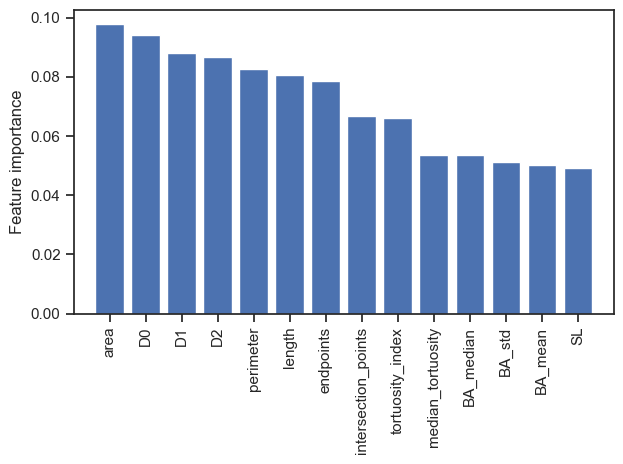

In [208]:

print('For real status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

forest = RandomForestClassifier(n_estimators=500,max_depth=4, max_features=1, 
                                random_state=1)

forest.fit(X_train, y_train)

prediction = forest.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, prediction))
print('Training F1: ', f1_score(y_train,prediction))
prediction = forest.predict(X_test)
print('Testing Accuracy: ', accuracy_score(y_test, prediction))
print('Testing F1: ', f1_score(y_test,prediction))

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = data.columns[:-2]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()

For predicted status
Training Accuracy:  1.0
Training F1:  1.0
Testing Accuracy:  0.7142857142857143
Testing F1:  0.75


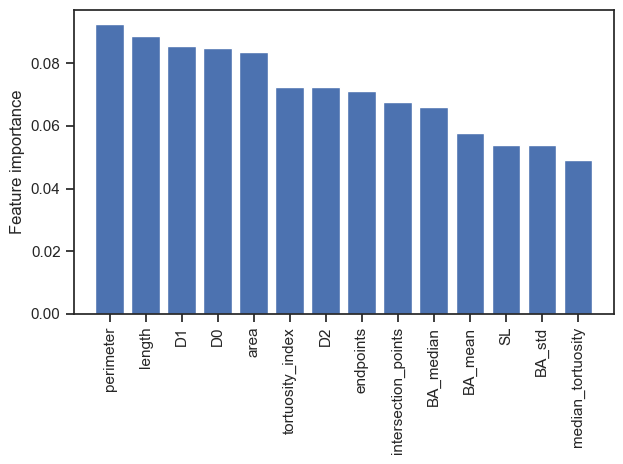

In [209]:
print('For predicted status')

X, y = data.iloc[:, :-2].values, data.iloc[:, -2].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=123, 
                     stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

forest = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=1,
                                random_state=1)

forest.fit(X_train, y_train)

prediction = forest.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, prediction))
print('Training F1: ', f1_score(y_train,prediction))
prediction = forest.predict(X_test)
print('Testing Accuracy: ', accuracy_score(y_test, prediction))
print('Testing F1: ', f1_score(y_test,prediction))

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = data.columns[:-2]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()